<a href="https://colab.research.google.com/github/CyberIngeniero/pokemon-api-rest/blob/main/Proyecto_NLP_Funcionando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Instalaciones previas

In [ ]:
%%capture
!pip uninstall -y transformers accelerate
!pip install transformers accelerate xformers emoji SentencePiece datasets

## Librerias

In [ ]:
import re
import emoji
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import sigmoid

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification,DataCollatorWithPadding
from datasets import load_dataset, concatenate_datasets, DatasetDict

## Verificando GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla V100-SXM2-16GB


In [ ]:
!nvidia-smi

Fri Jun  9 20:01:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      2MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Funciones

In [ ]:
# Limpieza de tweet
def preprocess_tweet(tweet):
    # Elimina los espacios en blanco al inicio y al final
    tweet = tweet.strip()
    # Elimina las menciones
    tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
    # Mantiene las palabras de los hashtags pero elimina el carácter hashtag
    tweet = re.sub(r'#(\w+)', r'\1', tweet)
    # Convierte los emojis a texto
    tweet = emoji.demojize(tweet)
    # Elimina caracteres especiales, excepto los dos puntos
    tweet = re.sub(r'[^\w\sáéíóúÁÉÍÓÚÑñ:]', '', tweet)
    # Convierte el tweet a minúsculas
    tweet = tweet.lower()
    # Elimina los espacios en blanco al inicio y al final
    tweet = tweet.strip()
    return tweet


In [ ]:
# Ajuste del tokenizador
def process(df):
    tokenized_inputs = tokenizer(
       df["Tweet"], padding="max_length", truncation=True
    )
    return tokenized_inputs

In [ ]:
# Crea un DataLoader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EmotionDataset(
        tweets=df.Tweet.to_numpy(),
        labels=df[emotions].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True
    )

In [ ]:
# Evalua el modelo
def evaluate_model(model, data_loader):
    model = model.eval()

    final_loss = 0
    counter = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            final_loss += loss.item()
            counter += 1

    return final_loss / counter

In [ ]:
# obtener predicciones
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            preds = torch.sigmoid(outputs.logits)
            preds = preds.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()

            predictions.extend(preds)
            real_values.extend(labels)

    predictions = np.array(predictions)
    real_values = np.array(real_values)
    return predictions, real_values

## Parametros

In [ ]:
# Definiendo las emociones
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

In [ ]:
# Cantidad de emociones
num_labels = len(emotions)

In [ ]:
# Definicion del modelo
model_id = "xlm-roberta-large"

In [ ]:
# Parámetros de entrenamiento
EPOCHS = 30
BATCH_SIZE = 32
MAX_LEN = 128
LEARNING_RATE = 1e-5
INITIAL_LR =  1e-5

## Tokenizador

In [ ]:
# Definiendo el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained(model_id)

## Lectura de datos

In [ ]:
# Cargando los datos
df = pd.read_csv('/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/data/sem_eval_train_es.csv')

In [ ]:
df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-01643,ajajjaa somos del clan twitteras perdidas pa e...,False,False,False,False,True,False,False,False,False,False,False
1,2018-Es-05142,la mala suerte del gato fichame la cara de hel...,False,False,False,True,False,False,False,True,False,False,False
2,2018-Es-05379,a mí tampoco me agrado mucho eso especialmente...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-00208,para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
4,2018-Es-01385,me encanta la terrible hipocresia y doble mora...,True,False,True,False,False,False,False,False,False,False,False


## Procesamiento

In [ ]:
# Limpiando los tweets
df['Tweet'] = df['Tweet'].apply(preprocess_tweet)

In [ ]:
df['Tweet']

0       ajajjaa somos del clan twitteras perdidas pa e...
1       la mala suerte del gato fichame la cara de hel...
2       a mí tampoco me agrado mucho eso especialmente...
3       para llevar a los bebes de un lugar a otro deb...
4       me encanta la terrible hipocresia y doble mora...
                              ...                        
3556    ahorita quisiera que mi preocupación más grand...
3557    el mayor criminal del país diciéndole delincue...
3558    mi prima de 4 años se ha enfadado conmigo porq...
3559                                      jajaja  ya seee
3560    quiero abrazar quiero querer me hace falta el ...
Name: Tweet, Length: 3561, dtype: object

## Split data

In [ ]:
# Separa los datos en un conjunto de entrenamiento y un conjunto de validación
train_data, val_data = train_test_split(df, test_size=0.2)

## Cargando el modelo

In [ ]:
# Cargando el modelo
model = XLMRobertaForSequenceClassification.from_pretrained(model_id, num_labels=len(emotions))

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_

## Ajustando ultimas capas del modelo

In [ ]:
# Ajustando ultimas capas del modelo
model.classifier.out_proj = torch.nn.Sigmoid()
model.classifier.out_proj = torch.nn.Linear(in_features=1024, out_features=num_labels)

# Configurando el modelo
model.config.hidden_dropout_prob = 0.5
model.config.attention_probs_dropout_prob = 0.5

## Clase: EmotionDataset

In [ ]:
# Prepara los datos para el modelo
class EmotionDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]
        encoding = tokenizer.encode_plus(
            tweet,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

## Cargando el modelo en GPU

In [ ]:
# Cargando el modelo en GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

## Creando los Dataset

In [ ]:
# Creamos los Datasets
train_dataset = EmotionDataset(
    tweets=train_data['Tweet'].to_numpy(),
    labels=train_data[emotions].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = EmotionDataset(
    tweets=val_data['Tweet'].to_numpy(),
    labels=val_data[emotions].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

## Creando Dataloaders

In [ ]:
# Creando los Dataloaders
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Definiendo Criterio y Optimizador

In [ ]:
# Definimos el criterio
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
criterion = BCEWithLogitsLoss()

# Inicializa el optimizador
# optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR, weight_decay=0.01)

# Inicializa el planificador de la tasa de aprendizaje
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

## Entrenando el modelo

In [ ]:
# Inicialización de las listas
train_losses = []
val_losses = []

# Inicializa la mejor puntuación de validación F1
best_val_f1 = 0

# Inicializa el contador de early stopping
early_stopping_counter = 0

# Establece el número máximo de épocas sin mejora para detener el entrenamiento
patience = 5

# Ciclo de entrenamiento
for epoch in range(EPOCHS):
    # Fase de entrenamiento
    model.train()
    total_train_loss = 0

    for batch in train_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        model.zero_grad()

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs.logits, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    # Fase de validación
    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_labels = []

    for batch in val_data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(outputs.logits, labels)
        total_val_loss += loss.item()

        # Obten las predicciones del modelo
        predictions = torch.sigmoid(outputs.logits)
        predictions = (predictions > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)

    # Calcula la puntuación F1
    val_f1 = f1_score(np.array(all_labels), np.array(all_predictions), average='samples', zero_division=1)
    print('------------------------------------------------------------------')
    print(f'Validation F1 Epoch {epoch + 1}: {val_f1}')

    # Verifica si esta es la mejor puntuación de validación F1 hasta ahora
    if val_f1 > best_val_f1:
        # Guarda el modelo
        torch.save(model.state_dict(), '/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/model/best_model.pt')
        best_val_f1 = val_f1
        early_stopping_counter = 0
    else:
        # Incrementa el contador de early stopping
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {patience}')
        if early_stopping_counter >= patience:
            print('Early stopping')
            break

    # Aquí es donde se aplica el planificador de la tasa de aprendizaje
    scheduler.step(avg_val_loss)

    print(f'Train Loss Epoch {epoch + 1}: {avg_train_loss}')
    print(f'Validation Loss Epoch {epoch + 1}: {avg_val_loss}')


------------------------------------------------------------------
Validation F1 Epoch 1: 0.16348761103319306
Train Loss Epoch 1: 0.3947656626781721
Validation Loss Epoch 1: 0.3700143721368578
------------------------------------------------------------------
Validation F1 Epoch 2: 0.4342215988779804
Train Loss Epoch 2: 0.3519717287481501
Validation Loss Epoch 2: 0.3197455585002899
------------------------------------------------------------------
Validation F1 Epoch 3: 0.5269284712482468
Train Loss Epoch 3: 0.3047735279195764
Validation Loss Epoch 3: 0.2915099819501241
------------------------------------------------------------------
Validation F1 Epoch 4: 0.5619915848527349
Train Loss Epoch 4: 0.2695059592134497
Validation Loss Epoch 4: 0.27501799994044834
------------------------------------------------------------------
Validation F1 Epoch 5: 0.5836372136512389
Train Loss Epoch 5: 0.24235599027590804
Validation Loss Epoch 5: 0.2811300191614363
-------------------------------------

## Guardando el modelo

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/model/exp1_model.pt')

## Monitoreo del Entrenamiento

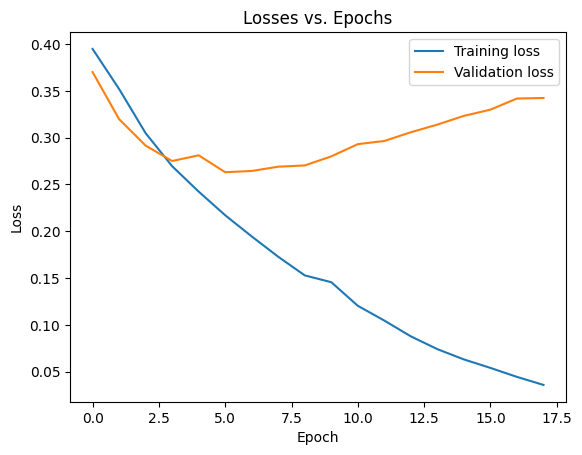

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses vs. Epochs')
plt.legend()
plt.show()

## Testeando el Modelo

In [ ]:
# leyendo data para testing
df_test = load_dataset('sem_eval_2018_task_1', 'subtask5.spanish', split='test')

# convirtiendo a pandas
test_data = df_test.to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/3561 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2854 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/679 [00:00<?, ? examples/s]

Dataset sem_eval_2018_task_1 downloaded and prepared to /root/.cache/huggingface/datasets/sem_eval_2018_task_1/subtask5.spanish/1.1.0/a7c0de8b805f1988b118882fb289ccfbbeb9085c7820b6f046b5887e234af182. Subsequent calls will reuse this data.


In [ ]:
test_data.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-07180,@Reforma QEPD 😢 Mis condolencias para sus fami...,False,False,False,False,False,False,False,False,True,False,False
1,2018-Es-00392,@Mubrutico @AlvaroVadin @aracnoideo Estoy enfa...,True,False,False,False,False,False,False,False,False,False,False
2,2018-Es-06102,@jotajordi13 @somhiserem @jmbartomeu Que estas...,True,False,False,False,False,False,False,False,False,False,False
3,2018-Es-05390,"""Tienes esa sonrisa que me gustaría ver cada d...",False,False,False,False,True,True,False,False,False,False,False
4,2018-Es-00153,Q horrible es querer dormir y no poder dormir ...,True,False,False,False,False,False,False,True,True,False,False


In [ ]:
# Procesando tweets de test
test_data['Tweet'] = test_data['Tweet'].apply(preprocess_tweet)

In [ ]:
test_data['Tweet']

0       qepd :crying_face: mis condolencias para sus f...
1       estoy enfadado con él  no saca la bici :face_w...
2       que estas enfadado por que no cojen los crack ...
3       tienes esa sonrisa que me gustaría ver cada dí...
4       q horrible es querer dormir y no poder dormir ...
                              ...                        
2849    cuánto odio hay en un país para que hasta una ...
2850    no soy egoista ni mala persona por responderte...
2851    259 1:40 luuu: noooo por que 259 1:42 luuu: y ...
2852    de estar enojada pase a llorar de llorar pase ...
2853    le clavan dos pepinos y uno segurito es a su palo
Name: Tweet, Length: 2854, dtype: object

In [ ]:
# testing dataset
test_dataset = EmotionDataset(
    tweets=test_data['Tweet'].to_numpy(),
    labels=test_data[emotions].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

In [ ]:
# testing dataloader
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# evaluando el modelo
test_loss = evaluate_model(model, test_data_loader)
print(f"Test Loss: {test_loss}")

Test Loss: 0.32547461224926844


In [ ]:
# Obteniendo las predicciones del conjunto de prueba
predictions, real_values = get_predictions(model, test_data_loader)

## Matriz de Confusión por cada Emoción

Emotion: anger
Accuracy: 0.8430273300630694
Precision: 0.7562568008705114
Recall: 0.7562568008705114
F1 Score: 0.7562568008705114


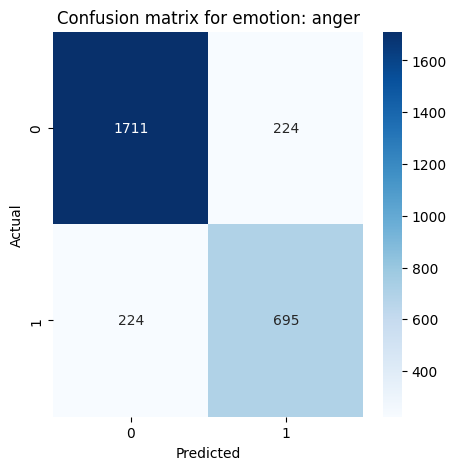

Emotion: anticipation
Accuracy: 0.897687456201822
Precision: 0.568075117370892
Recall: 0.37694704049844235
F1 Score: 0.45318352059925093


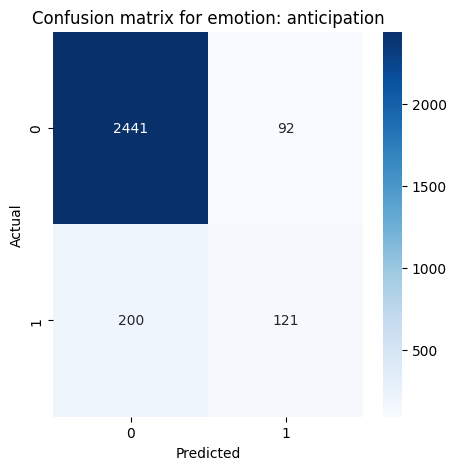

Emotion: disgust
Accuracy: 0.8598458304134547
Precision: 0.5308310991957105
Recall: 0.46808510638297873
F1 Score: 0.4974874371859297


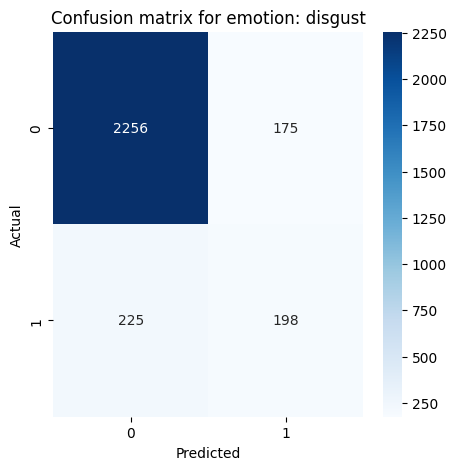

Emotion: fear
Accuracy: 0.937281009110021
Precision: 0.6976744186046512
Recall: 0.7046979865771812
F1 Score: 0.7011686143572621


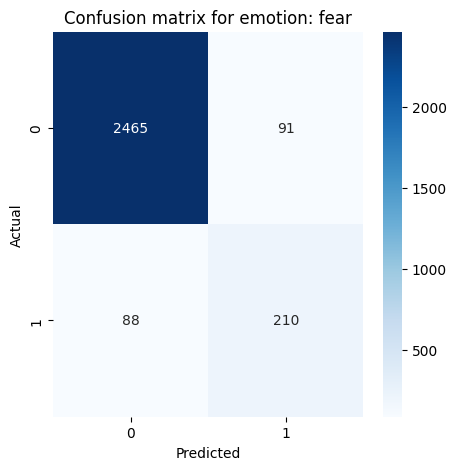

Emotion: joy
Accuracy: 0.897687456201822
Precision: 0.8127018299246501
Recall: 0.8648339060710195
F1 Score: 0.8379578246392897


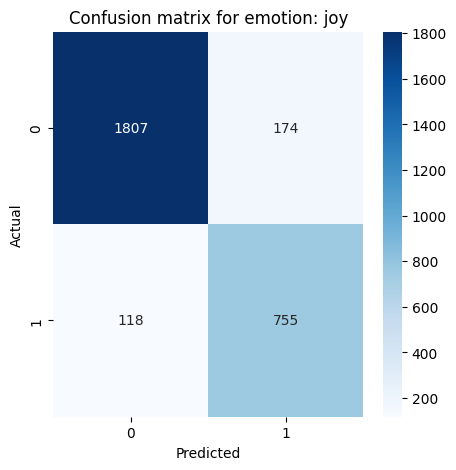

Emotion: love
Accuracy: 0.9463910301331465
Precision: 0.7053571428571429
Recall: 0.6448979591836734
F1 Score: 0.6737739872068229


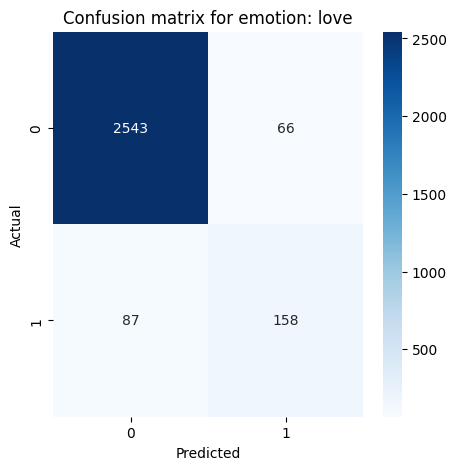

Emotion: optimism
Accuracy: 0.9050455501051157
Precision: 0.5136186770428015
Recall: 0.4748201438848921
F1 Score: 0.4934579439252336


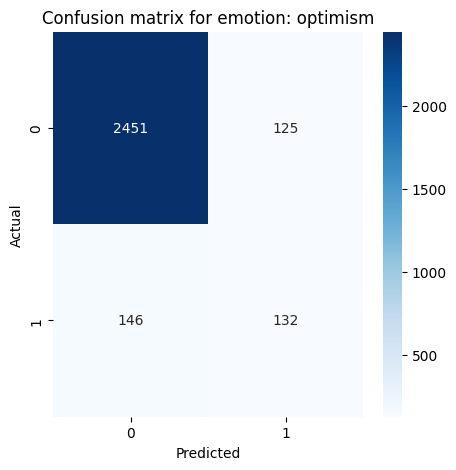

Emotion: pessimism
Accuracy: 0.8293622985283812
Precision: 0.5093023255813953
Recall: 0.44242424242424244
F1 Score: 0.47351351351351356


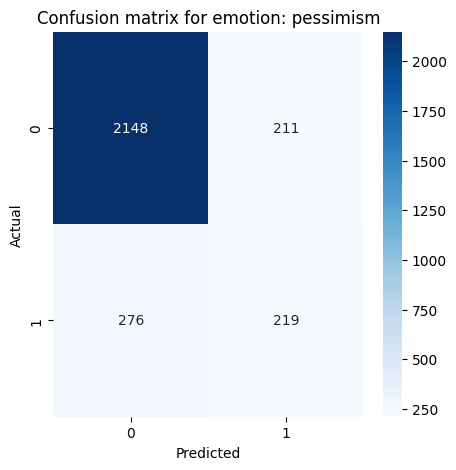

Emotion: sadness
Accuracy: 0.869656622284513
Precision: 0.7066869300911854
Recall: 0.7220496894409938
F1 Score: 0.7142857142857143


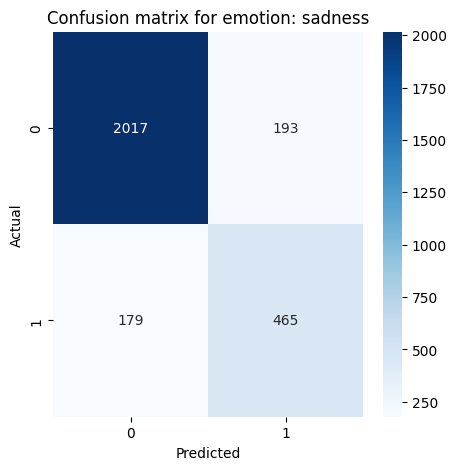

Emotion: surprise
Accuracy: 0.9548002803083392
Precision: 0.4492753623188406
Recall: 0.2540983606557377
F1 Score: 0.32460732984293195


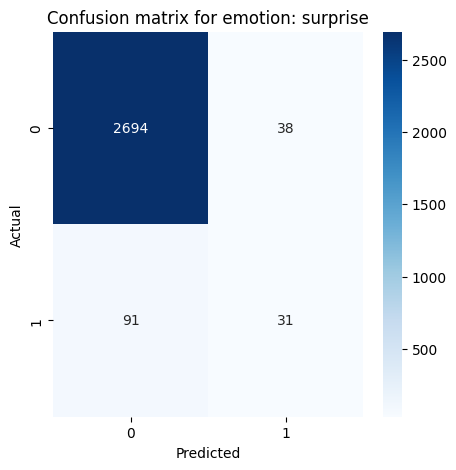

Emotion: trust
Accuracy: 0.9523475823405746
Precision: 0.4027777777777778
Recall: 0.23770491803278687
F1 Score: 0.2989690721649484


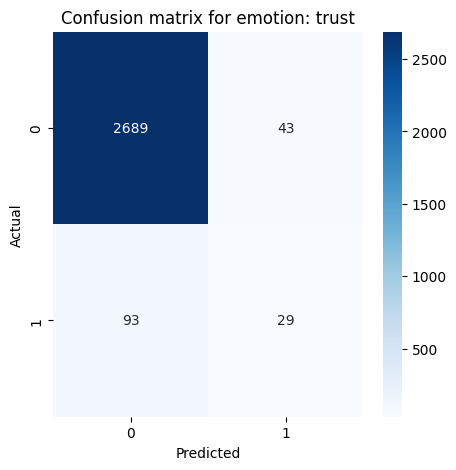

+--------------+--------------------+--------------------+---------------------+---------------------+
|   Emotion    |      Accuracy      |     Precision      |       Recall        |      F1-Score       |
+--------------+--------------------+--------------------+---------------------+---------------------+
|    anger     | 0.8430273300630694 | 0.7562568008705114 | 0.7562568008705114  | 0.7562568008705114  |
| anticipation | 0.897687456201822  | 0.568075117370892  | 0.37694704049844235 | 0.45318352059925093 |
|   disgust    | 0.8598458304134547 | 0.5308310991957105 | 0.46808510638297873 | 0.4974874371859297  |
|     fear     | 0.937281009110021  | 0.6976744186046512 | 0.7046979865771812  | 0.7011686143572621  |
|     joy      | 0.897687456201822  | 0.8127018299246501 | 0.8648339060710195  | 0.8379578246392897  |
|     love     | 0.9463910301331465 | 0.7053571428571429 | 0.6448979591836734  | 0.6737739872068229  |
|   optimism   | 0.9050455501051157 | 0.5136186770428015 | 0.474820143884

In [ ]:
# Crear un diccionario para guardar las métricas
metrics = {
    'Emotion': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': []
}

# Para cada emoción
for i, emotion in enumerate(emotions):
    preds = predictions[:, i]
    labels = real_values[:, i]

    # Binarizar las predicciones
    preds = (preds > 0.5).astype(int)

    # Guardar las métricas en el diccionario
    metrics['Emotion'].append(emotion)
    metrics['Accuracy'].append(accuracy_score(labels, preds))
    metrics['Precision'].append(precision_score(labels, preds))
    metrics['Recall'].append(recall_score(labels, preds))
    metrics['F1-Score'].append(f1_score(labels, preds))

    print(f"Emotion: {emotion}")
    print(f"Accuracy: {metrics['Accuracy'][-1]}")
    print(f"Precision: {metrics['Precision'][-1]}")
    print(f"Recall: {metrics['Recall'][-1]}")
    print(f"F1 Score: {metrics['F1-Score'][-1]}")

    # Calcular la matriz de confusión
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion matrix for emotion: {emotion}')
    plt.show()

# Mostrar el diccionario de métricas en una tabla
print(tabulate(metrics, headers='keys', tablefmt='pretty'))


## Buscando un threshold optimo por Emoción

In [ ]:
# buscando el threshold por emocion
best_thresholds = {}

# Para cada emoción
for i, emotion in enumerate(emotions):
    emotion_scores = predictions[:, i]
    labels = real_values[:, i]

    best_f1 = 0
    best_threshold = 0

    # Probar umbrales desde 0.1 hasta 0.9
    for threshold in np.arange(0.1, 1, 0.1):
        preds = (emotion_scores > threshold).astype(int)

        f1 = f1_score(labels, preds)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    best_thresholds[emotion] = round(best_threshold, 2)

pprint(best_thresholds)

{'anger': 0.3,
 'anticipation': 0.3,
 'disgust': 0.1,
 'fear': 0.5,
 'joy': 0.5,
 'love': 0.2,
 'optimism': 0.4,
 'pessimism': 0.2,
 'sadness': 0.4,
 'surprise': 0.3,
 'trust': 0.2}


## Datos para Evaluación

In [ ]:
# carga del modelo
model_path = '/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/model/best_model.pt'

# seleccionando GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# cargando el modelo
model = XLMRobertaForSequenceClassification.from_pretrained(model_id, num_labels=len(emotions))
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)


cuda


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.o

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_fe

In [ ]:
df_eval = pd.read_csv('/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/data/sem_eval_test_blank_es.csv')

In [ ]:
df_eval

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contr...
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había ll...
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondi...
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años ..."
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de un...
...,...,...
674,2018-Es-06551,@tccharless -Peligro al volante -Tec -Los San...
675,2018-Es-02782,Vamos a ver q sucedio en mi barrio en los 90 #...
676,2018-Es-01308,@kopexinfinity FELICIDADES FER 💕 QUE ESTA PASA...
677,2018-Es-02136,@PabloEmanuel299 LAMENTO MI CONFUSIÓN DE RAMA ...


In [ ]:
# Procesando tweets de test
df_eval['Tweet'] = df_eval['Tweet'].apply(preprocess_tweet)

In [ ]:
# 2. Tokenización y conversión a tensores
inputs = tokenizer(df_eval['Tweet'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

In [ ]:
# 3. Obtención de las predicciones del modelo
model.eval()
with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask)[0]

In [ ]:
# Convertir las logits a probabilidades
probs = torch.sigmoid(logits).cpu().numpy()

In [ ]:
# Convertir las probabilidades a etiquetas binarias
# Puedes ajustar el umbral según tus necesidades, aquí usamos 0.5 como ejemplo
threshold = 0.5
preds = (probs >= threshold).astype(int)

In [ ]:
# Crear un dataframe con las predicciones
df_preds = pd.DataFrame(preds, columns=emotions)

In [ ]:
# Convertir las predicciones a booleano
df_preds = df_preds.astype(bool)

In [ ]:
# Concatenar el ID y los tweets con las predicciones
df_out = pd.concat([df_eval, df_preds], axis=1)

In [ ]:
df_out.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-Es-06697,no me pienso perder la pelea de mcgregor contr...,False,True,False,False,False,False,False,False,False,False,False
1,2018-Es-05385,yo preocupada pensando que mi papá ya había ll...,False,False,False,True,False,False,False,False,True,False,False
2,2018-Es-03777,pucha ya no me sirven todos los carros a rondi...,False,False,False,False,True,False,False,True,False,False,False
3,2018-Es-02175,si estar contigo es un delito hago cien años e...,True,False,False,False,True,False,False,False,False,False,False
4,2018-Es-00726,perfect y de una mansa ni que terrible plr,False,False,False,False,True,False,False,False,False,False,False


In [ ]:
df_out = df_out.drop(columns=['Tweet'])

In [ ]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            679 non-null    object
 1   anger         679 non-null    bool  
 2   anticipation  679 non-null    bool  
 3   disgust       679 non-null    bool  
 4   fear          679 non-null    bool  
 5   joy           679 non-null    bool  
 6   love          679 non-null    bool  
 7   optimism      679 non-null    bool  
 8   pessimism     679 non-null    bool  
 9   sadness       679 non-null    bool  
 10  surprise      679 non-null    bool  
 11  trust         679 non-null    bool  
dtypes: bool(11), object(1)
memory usage: 12.7+ KB


In [ ]:
output_path = '/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/output/soluciones_nibaldo_pino_araya.csv'
df_out.to_csv(output_path)

## Clase Genera Predicciones

In [ ]:
class EmotionPredictor:

    def __init__(self, model_path, model_id, emotions, tokenizer, preprocess_tweet):
        self.model_path = model_path
        self.model_id = model_id
        self.emotions = emotions
        self.tokenizer = tokenizer
        self.preprocess_tweet = preprocess_tweet
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # cargar el modelo
        self.model = XLMRobertaForSequenceClassification.from_pretrained(self.model_id, num_labels=len(self.emotions))
        self.model.load_state_dict(torch.load(self.model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()

    def predict(self, df_eval, threshold=0.5):
        # procesamiento de los tweets
        df_eval['Tweet'] = df_eval['Tweet'].apply(self.preprocess_tweet)

        # Tokenización y conversión a tensores
        inputs = self.tokenizer(df_eval['Tweet'].tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
        input_ids = inputs['input_ids'].to(self.device)
        attention_mask = inputs['attention_mask'].to(self.device)

        # obtención de las predicciones del modelo
        with torch.no_grad():
            logits = self.model(input_ids, attention_mask=attention_mask)[0]

        # convertir las logits a probabilidades
        probs = torch.sigmoid(logits).cpu().numpy()

        # convertir las probabilidades a etiquetas binarias
        preds = (probs >= threshold).astype(int)

        # crear un dataframe con las predicciones
        df_preds = pd.DataFrame(preds, columns=self.emotions)
        df_preds = df_preds.astype(bool)

        # Concatenar el ID y los tweets con las predicciones
        df_out = pd.concat([df_eval, df_preds], axis=1)
        df_out = df_out.drop(columns=['Tweet'])

        return df_out


In [ ]:
predictor = EmotionPredictor(model_path=model_path,
                             model_id=model_id,
                             emotions=emotions,
                             tokenizer=tokenizer,
                             preprocess_tweet=preprocess_tweet)


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.o

In [ ]:
df_eval = pd.read_csv('/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/data/sem_eval_test_blank_es.csv')
df_out = predictor.predict(df_eval)

output_path = '/content/drive/MyDrive/Estudios/Master_IA/NLP/Proyecto NLP/output/soluciones_nibaldo_pino_araya2.csv'
df_out.to_csv(output_path, index=False)